# Import

In [2]:
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pvcracks.utils import img_functions
import os

from pvcracks.utils import viz_functions, train_functions

---
# Utility Functions

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def load_dataset(root, channeled=True):
    if not channeled:
        transformers = img_functions.Compose(
            [
                img_functions.FixResize(256),
                img_functions.ToTensor(),
                img_functions.Normalize(),
            ]
        )
    else:
        # Channeled dataset
        transformers = img_functions.Compose(
            [
                img_functions.ChanneledFixResize(256),
                img_functions.ToTensor(),
                img_functions.Normalize(),
            ]
        )

    val_dataset = img_functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return val_dataset

---
# Plotting Methods

In [5]:
def two_row_inference_and_show(idx, root, weight_path, category_mapping, threshold=0.5):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = train_functions.load_device_and_model(
        category_mapping, existing_weight_path=weight_path
    )

    return viz_functions.channeled_inference_and_show(
        val_loader, device, model, category_mapping, idx, threshold
    )

In [6]:
def one_row_inference_and_show(idx, root, weight_path, category_mapping, threshold=0.5):
    val_dataset = load_dataset(root, channeled=False)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = train_functions.load_device_and_model(
        category_mapping, existing_weight_path=weight_path
    )

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)

    raw_img, _ = val_loader.dataset.__getraw__(idx)

    # --- Run inference ---
    logits = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze(0)
    pred_mask = np.argmax(logits, axis=0)

    gt_mask = mask.cpu().numpy()

    # --- Visualization ---
    n_classes = len(category_mapping)

    class_names = [f"({k}) {v}" for k, v in category_mapping.items()]
    cmap = mpl.colormaps["viridis"].resampled(n_classes)  # define the colormap
    cmaplist = [cmap(i) for i in range(n_classes)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

    ax[0].imshow(raw_img.convert("L"), cmap="viridis", interpolation="None")
    ax[0].axis("off")
    ax[0].set_title("Raw Image")

    ax[1].imshow(gt_mask, cmap="viridis")
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(pred_mask, cmap="viridis", interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()
    for c, class_name in zip(cmaplist, class_names):
        patch = mpatches.Patch(color=c, label=class_name, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    ax[2].set_title("New Model Prediction")

    plt.tight_layout()
    plt.show()

In [7]:
def raw_model_outputs(idx, root, weight_path, category_mapping):
    val_dataset = load_dataset(root, channeled=False)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    device, model = train_functions.load_device_and_model(
        category_mapping, existing_weight_path=weight_path
    )

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)

    test_res = (
        model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    )  # .argmax(axis = 0)
    test_res = np.argmax(test_res, axis=0)

    test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res_act = sigmoid(test_res_chan)

    yslice = 130
    # yslice= 180
    # xmax = 60
    # ymax = 256

    sliced = test_res_act[:, yslice, :]
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)

    for i in range(sliced.shape[0]):
        ax[0].fill_between(
            np.arange(0, 256, 1), sliced[i], alpha=0.3, label=category_mapping[i]
        )
    ax[0].legend()
    ax[0].set_ylabel(f"Activated model outputs at y = {yslice}", fontsize="xx-large")

    ax[1].imshow(test_res_chan.sum(axis=0), cmap="magma")
    ax[1].set_aspect("auto")
    ax[1].axhline(
        yslice, ls="--", c="black", alpha=0.9, label=f"y = {yslice}", linewidth=3
    )
    ax[1].legend()
    ax[1].set_title("Raw model outputs", fontsize="xx-large")
    ax[1].set_ylabel("y pixel position", fontsize="xx-large")
    fig.supxlabel("x pixel position", fontsize="xx-large")
    fig.tight_layout()

    ax[0].legend(fontsize="xx-large")  # or a number, e.g., fontsize=14
    ax[1].legend(fontsize="xx-large")

---
# Running plot-creating code

In [8]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/"
)
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_Optimized/model.pt"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_Optimized/model_epoch39_paramaters-wandb.pt"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty10/epoch_19/model.pt"

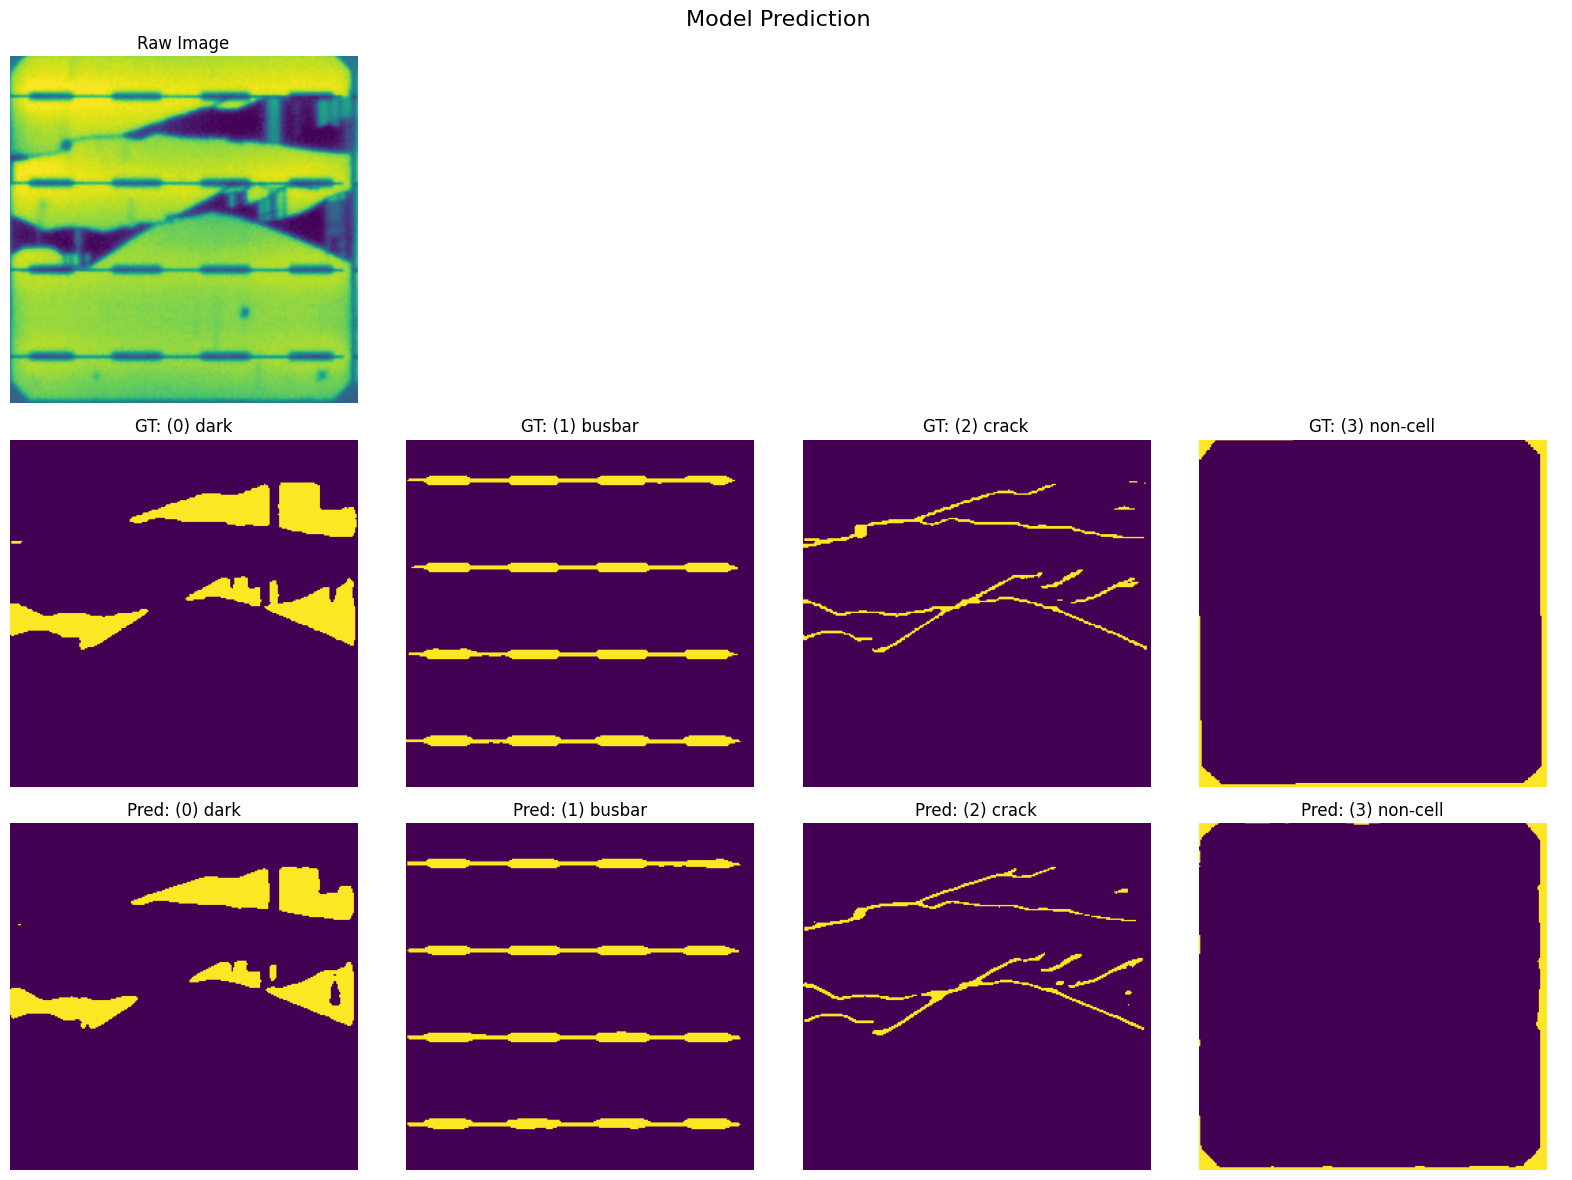

In [9]:
two_row_inference_and_show(7, root, weight_path, category_mapping)
# for i in range(0, 101):
#     print(i)
#     two_row_inference_and_show(i, root, weight_path, category_mapping)

0


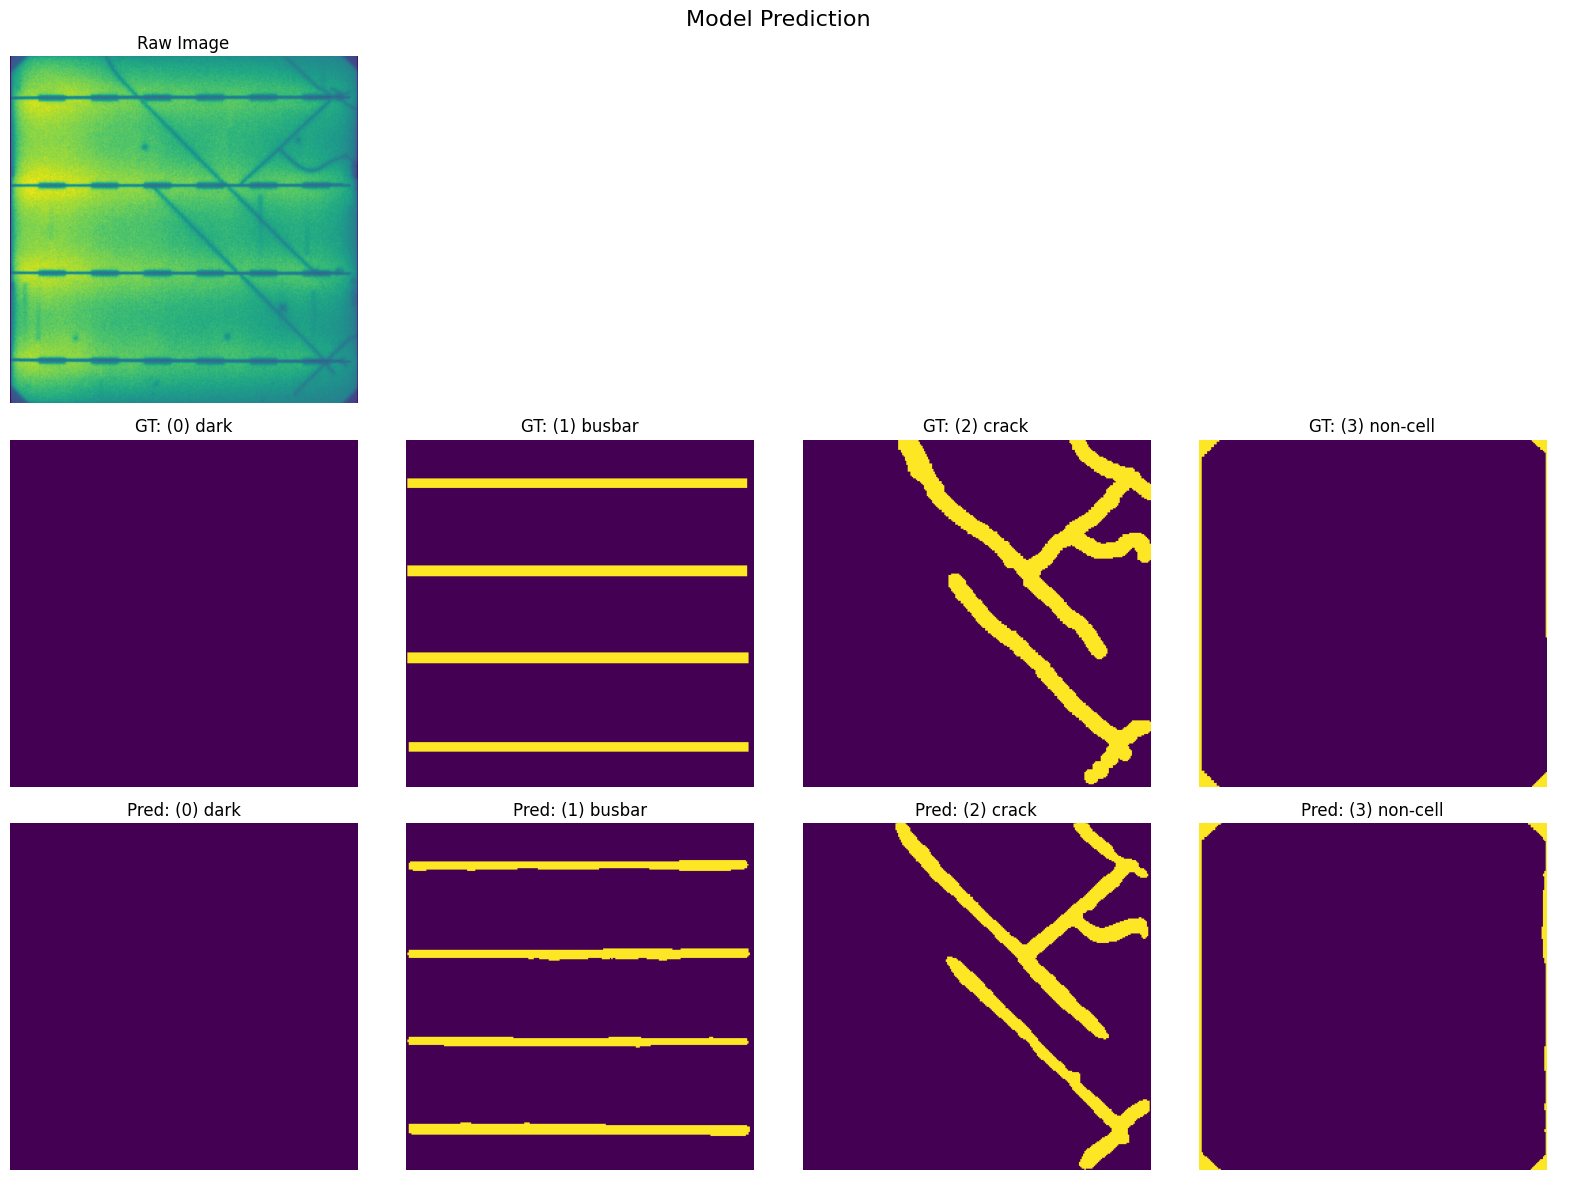

In [10]:
for i in range(0, 101):
    print(i)
    two_row_inference_and_show(i, root, weight_path, category_mapping)
    break

---


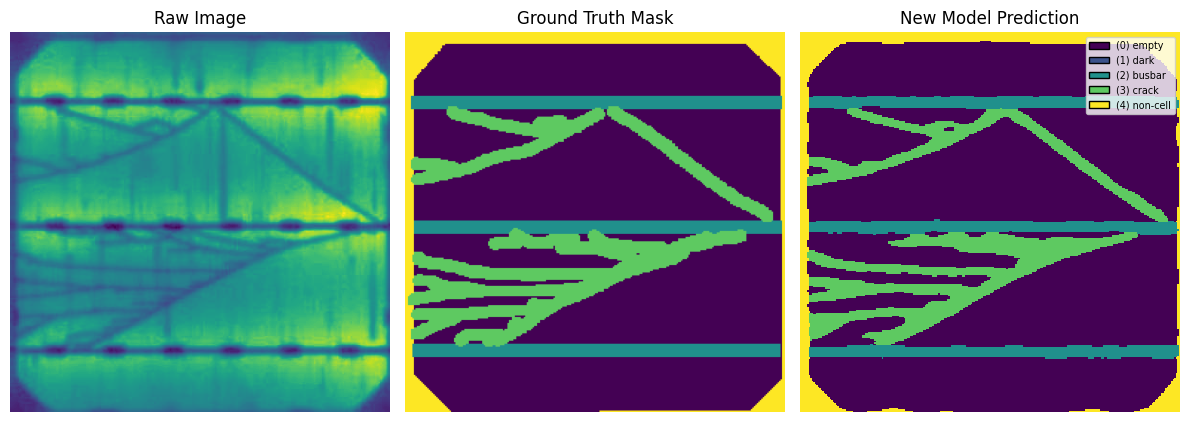

In [11]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
root = Path(
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
)
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/checkpoints/Combined_CWRU_SE_Dupont_and_LBNL_Mono2/epoch_30/Combined_CWRU_SE_Dupont_and_LBNL_Mono.pt"

one_row_inference_and_show(21, root, weight_path, category_mapping)

# for i in range(0, 101):
#     print(i)
#     one_row_inference_and_show(i, root, weight_path, category_mapping)

---

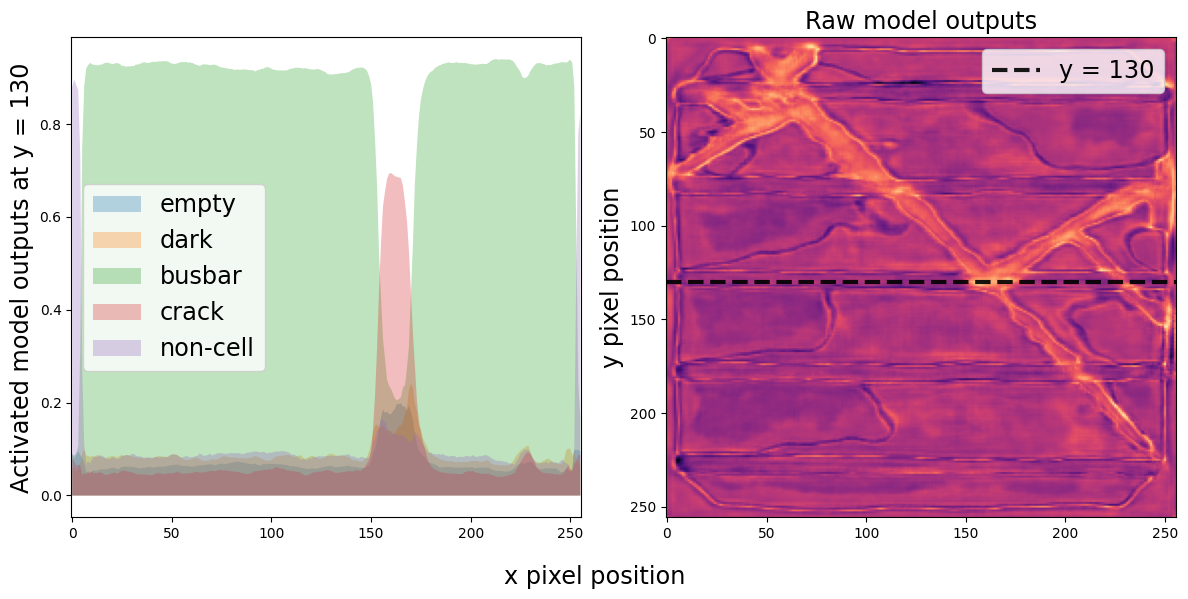

In [12]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/checkpoints/Fresh_Combined_CWRU_LBNL_ASU1/epoch_30/model.pt"


bu_name = "bu_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
cr_name = "cr_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
ann_dir = root + "ann/val/"
val_dataset = load_dataset(root, channeled=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
cr_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, cr_name))
)[0]
bu_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, bu_name))
)[0]

raw_model_outputs(cr_idx, root, weight_path, category_mapping)

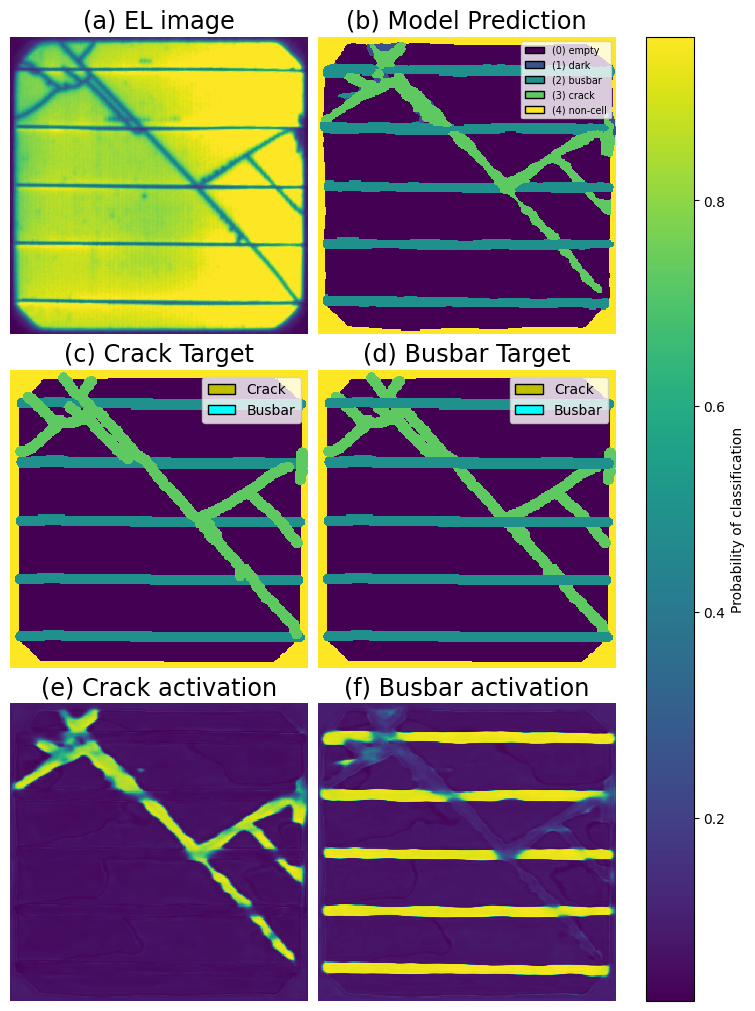

In [20]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/checkpoints/Fresh_Combined_CWRU_LBNL_ASU1/epoch_30/model.pt"

bu_name = "bu_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
cr_name = "cr_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
ann_dir = root + "ann/val/"
val_dataset = load_dataset(root, channeled=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
cr_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, cr_name))
)[0]
bu_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, bu_name))
)[0]


clim = (0, 4)

device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

# img, cr_mask = train_loader.dataset. __getitem__(cr_idx)
# img, bu_mask = train_loader.dataset. __getitem__(bu_idx)

img, cr_mask = val_loader.dataset.__getitem__(cr_idx)
img, bu_mask = val_loader.dataset.__getitem__(bu_idx)
img = img.to(device)

test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

model_prediction = np.argmax(test_res_chan, axis=0)

bu_layer = test_res_act[2]
cr_layer = test_res_act[3]

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 10), layout="compressed")

###
# img, _ = train_loader.dataset.__getraw__(cr_idx)
img, _ = val_loader.dataset.__getraw__(cr_idx)
ax[0, 0].imshow(img, cmap="gray", interpolation="None")
ax[0, 0].axis("off")
ax[0, 0].set_title("(a) EL image", fontsize="xx-large")
###
ax[0, 1].imshow(model_prediction, cmap="viridis", clim=clim, interpolation="none")
ax[0, 1].axis("off")
ax[0, 1].set_title("(b) Model Prediction", fontsize="xx-large")
handles, labels = ax[0, 1].get_legend_handles_labels()
cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
cmaplist = [cmap(i) for i in range(5)]
for c, classlabel in zip(cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]):
    patch = mpatches.Patch(color=c, label=classlabel, ec="k")
    handles.append(patch)
ax[0, 1].legend(handles=handles, fontsize="x-small")
###
ax[1, 0].imshow(cr_mask, cmap="viridis", interpolation="None")
ax[1, 0].axis("off")
ax[1, 0].set_title("(c) Crack Target", fontsize="xx-large")
handles, labels = ax[1, 0].get_legend_handles_labels()
yellow_patch = mpatches.Patch(color="y", label="Crack", ec="k")
handles.append(yellow_patch)
cyan_patch = mpatches.Patch(color="cyan", label="Busbar", ec="k")
handles.append(cyan_patch)
ax[1, 0].legend(handles=handles)
###
ax[1, 1].imshow(bu_mask, cmap="viridis", interpolation="None")
ax[1, 1].axis("off")
ax[1, 1].set_title("(d) Busbar Target", fontsize="xx-large")
handles, labels = ax[1, 1].get_legend_handles_labels()
yellow_patch = mpatches.Patch(color="y", label="Crack", ec="k")
handles.append(yellow_patch)
cyan_patch = mpatches.Patch(color="cyan", label="Busbar", ec="k")
handles.append(cyan_patch)
ax[1, 1].legend(handles=handles)
###
ax[2, 0].imshow(cr_layer, cmap="viridis", interpolation="None")
ax[2, 0].axis("off")
ax[2, 0].set_title("(e) Crack activation", fontsize="xx-large")
###
im = ax[2, 1].imshow(bu_layer, cmap="viridis", interpolation="None")
ax[2, 1].axis("off")
ax[2, 1].set_title("(f) Busbar activation", fontsize="xx-large")
fig.colorbar(im, ax=ax, label="Probability of classification")